In [1]:
import pandas as pd
import altair as alt

# Part 1 - Data Cleaning

## Data Loading
We load the data, provided in `hw2-crowd-data.csv`

In [2]:
df_cars = pd.read_csv("hw2-crowd-data.csv")

In [3]:
# what is the length of my dataframe?
len(df_cars)

458

## Data Cleaning
You need to clean the rows and columns of data using Pandas.  Insert the code (and descriptions of the code in markdown) in this subsection.

In [4]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Car Make              458 non-null    object 
 1   Car Model             457 non-null    object 
 2   Dealer or Individual  453 non-null    object 
 3   Price                 456 non-null    float64
 4   Year                  458 non-null    int64  
 5   Location              446 non-null    object 
 6   Mileage               449 non-null    float64
 7   Doors                 440 non-null    object 
 8   Color                 454 non-null    object 
 9   Transmission          455 non-null    object 
 10  VIN#                  452 non-null    object 
 11  Engine                444 non-null    object 
 12  Description           354 non-null    object 
 13  Web link              457 non-null    object 
 14  Screenshot            435 non-null    object 
dtypes: float64(2), int64(1)

### Checking for Duplicate Values

In [5]:
df_cars.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
453    False
454    False
455    False
456    False
457    False
Length: 458, dtype: bool

Out of all the columns, I want to mainly check for duplicates in VIN# , because it has to be unique for this case.

In [7]:
df_cars.duplicated(subset='VIN#', keep=False).sum()

34

In [8]:
df_cars.drop_duplicates(subset='VIN#', keep='first', inplace=True)

In [9]:
df_cars.duplicated(subset='VIN#', keep=False).sum()

0

Now the duplicates have been dropped.

### Checking for Missing values 

In [10]:
df_cars.isnull().sum()

Car Make                 0
Car Model                1
Dealer or Individual     5
Price                    2
Year                     0
Location                11
Mileage                  7
Doors                   16
Color                    4
Transmission             3
VIN#                     1
Engine                  13
Description             99
Web link                 1
Screenshot              23
dtype: int64

There is 1 mising value for Car Model, which I think is better to drop.

In [12]:
df_cars = df_cars.dropna(subset=['Car Model'])

In [30]:
pd.options.mode.chained_assignment = None

Dealer or Individual,Transmission,Engine,Doors : For the missing values, the most common type in the dataset

In [31]:
df_cars['Dealer or Individual'].fillna(df_cars['Dealer or Individual'].mode()[0],inplace=True)
df_cars['Location'].fillna(df_cars['Location'].mode()[0],inplace=True)
df_cars['Doors'].fillna(df_cars['Doors'].mode()[0],inplace=True)
df_cars['Transmission'].fillna(df_cars['Transmission'].mode()[0],inplace=True)
df_cars['Engine'].fillna(df_cars['Engine'].mode()[0],inplace=True)                           

For Price , imputing missing prices based on the median price of similar cars (same make, model, and year).

In [39]:
df_cars['Price'].fillna(df_cars.groupby(['Car Make', 'Car Model', 'Year'])['Price'].transform('median'),inplace=True)

For Mileage, imputing missing values using the average mileage of cars of the same make, model, year.

In [40]:
df_cars['Mileage'].fillna(df_cars.groupby(['Car Make', 'Car Model', 'Year'])['Mileage'].transform('mean'),inplace=True)

For Colors, The Missing values can be labeled as 'Unknown', assuming that color might not significantly impact analysis focused on price, mileage specifications.

For Description, given that 104 values are missing, its best to fill these with a placeholder like 'Description not provided'

For Weblink, Screenshot, simply labeling it as 'Not available', as web links and screenshots are usually not crucial for statistical analysis.

In [41]:
df_cars['Color'].fillna('Unknown',inplace=True)
df_cars['Description'].fillna('Description not provided',inplace=True)
df_cars['Web link'].fillna('Not available',inplace=True)
df_cars['Screenshot'].fillna('Not available',inplace=True)

 VIN# is crucial for analysis so excluding rows with missing VINs from your analysis.

In [42]:
df_cars = df_cars.dropna(subset=['VIN#'])

In [46]:
df_cars[df_cars.isnull().any(axis=1)]

,Car Make,Car Model,Dealer or Individual,Price,Year,Location,Mileage,Doors,Color,Transmission,VIN#,Engine,Description,Web link,Screenshot


So, all the missing values are now handled.

### Handling inconsistencies 

Location : Location data appears to include dealership names and locations. I want to separate this to only include city and state.

In [48]:
df_cars['Location'] = df_cars['Location'].apply(lambda x: x.split(' in ')[-1])  #referred stackoverflow

The Color column contains exterior and interior colors with different formats.

In [66]:
df_cars['Color'] = df_cars['Color'].apply(lambda x: x.replace('(ext)', '').replace('&', '').replace('(int)', '').strip())

For Engine, I want to extract the displacement and cylinder type, and standardize the notation for cylinder configuration:

In [69]:
import re

df_cars['Standardized Engine'] = df_cars['Engine'].apply(lambda x: re.sub(r'(?i)(\d\.\d)L\s*([I4|V6|Cylinder]+).*', r'\1L \2', x).replace('Cylinder', 'Cyl').replace('I4', '4-Cyl').replace('V6', '6-Cyl').strip())

Just to make sure the Car Make and Car Model data is consistent in a standard format.

In [74]:
df_cars['Car Make'] = df_cars['Car Make'].str.upper().str.strip()
df_cars['Car Model'] = df_cars['Car Model'].str.upper().str.strip()

Viewing the data after cleaning :

In [75]:
df_cars

,Car Make,Car Model,Dealer or Individual,Price,Year,Location,Mileage,Doors,Color,Transmission,VIN#,Engine,Description,Web link,Screenshot,Standardized Engine
0,TOYOTA,COROLLA,Dealer,16799.0,2019,"Cheboygan, MI",61807.0,4,Silver Black,Automatic,2T1BURHE0KC161295,1.8L I4 DOHC,"Front-wheel drive, CVT transmission, automatic...",https://www.ferneliustoyota.net/inventory/used...,https://drive.google.com/open?id=1zXCuz7PcqJZA...,1.8L 4-Cyl
1,TOYOTA,RAV4,Dealer,33999.0,2021,"Marquette, MI",35988.0,4,Silver Sky Black,Automatic,2T3A1RFV3MW173876,I-4 cyl,"All-wheel drive, lane assist, power moonroof, ...",https://www.riversidetoyotamarquette.com/used/...,https://drive.google.com/open?id=1TtYkyqq7U6c1...,I-4 cyl
2,TOYOTA,RAV4,Dealer,36575.0,2021,"Escanaba, MI",18177.0,4,Silver Sky Gray,Automatic,2T3N1RFV3MC146163,I-4 cyl,"All-wheel drive, parking sensors, navigation s...",https://www.riversidetoyotamarquette.com/used/...,https://drive.google.com/open?id=1wjIhrGArk56d...,I-4 cyl
3,TOYOTA,RAV4,Dealer,32999.0,2022,"Escanaba, MI",23043.0,4,Midnight Black Black,Automatic,2T3P1RFV5NW280956,I-4 cyl,"Lane assist, rear parking camera, auto highbea...",https://www.riversidetoyotamarquette.com/used/...,https://drive.google.com/open?id=1R9Ejfpz6u2eU...,I-4 cyl
4,TOYOTA,RAV4,Dealer,26999.0,2021,"Marquette, MI",52091.0,4,Gray Black,Automatic,2T3P1RFV6MC246993,I-4 cyl,"Lane assist, rear parking camera, automatic hi...",https://www.riversidetoyotamarquette.com/certi...,https://drive.google.com/open?id=1o96XSGjg7Sia...,I-4 cyl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,TOYOTA,RAV4,Dealer,21000.0,2021,"Hemet, CA",68034.0,4,Midnight Black Metallic,Automatic,2T3W1RFV1MW115061,2.5L I4,One Owner | NO Accidents | Bluetooth | WiFi | ...,https://www.cargurus.com/Cars/inventorylisting...,https://drive.google.com/open?id=1ISwo5Dr7TIFs...,2.5L 4-Cyl
454,TOYOTA,RAV4,Dealer,13997.0,2015,"Temecula, CA",140769.0,4,Super White,Automatic,2T3WFREV0FW142824,2.5L I4,Our Super White One Owner 2015 Toyota RAV4 XLE...,https://www.cargurus.com/Cars/inventorylisting...,https://drive.google.com/open?id=1B51YacWQO2C1...,2.5L 4-Cyl
455,TOYOTA,RAV4,Dealer,19895.0,2016,"Escondido, CA",72466.0,4,Magnetic Gray,Automatic,JTMYFREV4GJ067733,2.5L I4,"Recent Arrival! Advanced Technology Package, A...",https://www.cargurus.com/Cars/inventorylisting...,https://drive.google.com/open?id=1Gwk6yL0o4C3-...,2.5L 4-Cyl
456,TOYOTA,COROLLA,Dealer,19895.0,2023,"Buena Park, CA",19242.0,4,Silver,Automatic,5YFB4MDE1PP009817,2L I4,Classic Silver Metallic 2023 Toyota Corolla LE...,https://www.cargurus.com/Cars/inventorylisting...,https://drive.google.com/open?id=1VICpxkMeb7Q8...,2L 4-Cyl


## Export Cleaned Data
Save the output of your data cleaning to `hw2-clean-data.csv`

In [76]:
df_cars.to_csv("hw2-clean-data.csv")

# Part 2:  Exploratory Data Analysis
At a minimum, the EDA should include looking at some summary statistics, recognizing any issues with the data or key insights, and visual inspection of important data columns. We expect at least 3 visualizations.

In [77]:
df_cars.describe()

,Price,Year,Mileage
count,435.000000,435.000000,435.000000
mean,19684.110299,2174.432184,63952.142437
std,7857.027928,3277.648678,51031.928062
min,3900.000000,2006.000000,0.000000
25%,13997.500000,2014.000000,22454.500000
50%,19398.000000,2018.000000,57377.000000
75%,24924.500000,2021.000000,94767.000000
max,46461.000000,70378.000000,264997.000000


Generating counts for categorical columns to understand the distribution

In [80]:
print(df_cars.isnull().sum())

Car Make                0
Car Model               0
Dealer or Individual    0
Price                   0
Year                    0
Location                0
Mileage                 0
Doors                   0
Color                   0
Transmission            0
VIN#                    0
Engine                  0
Description             0
Web link                0
Screenshot              0
Standardized Engine     0
dtype: int64


##### Visualizing Price Distribution

### Distribution Plot for Prices

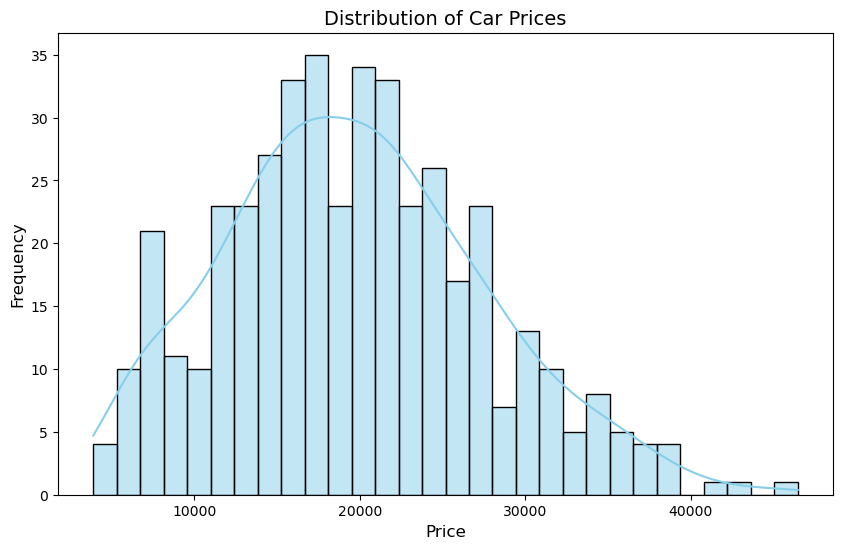

In [100]:
plt.figure(figsize=(10, 6))
sns.histplot(df_cars['Price'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Car Prices', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### Line Plot: Show the trend of average car prices over the years.

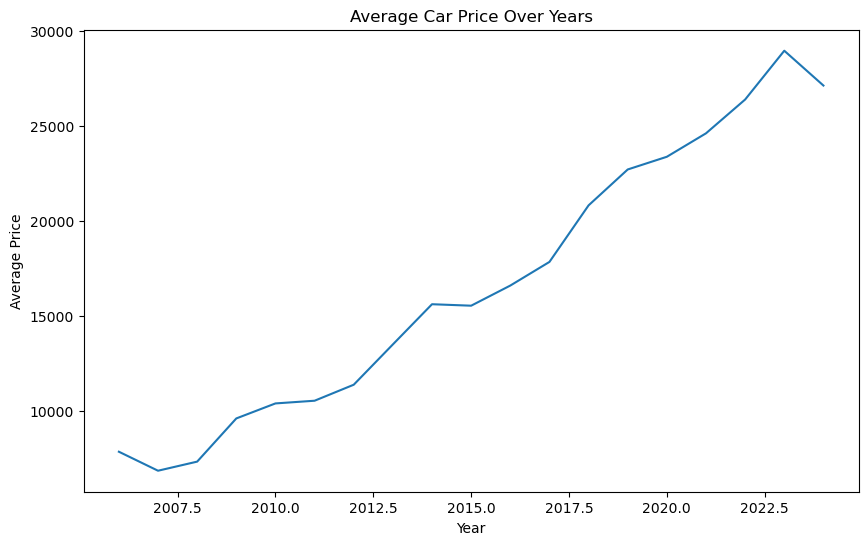

In [133]:
df_filtered = df_cars[df_cars['Year'] != 70378] # I missed this while cleaning the data.
avg_price_by_year = df_filtered.groupby('Year')['Price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Price', data=avg_price_by_year)
plt.title('Average Car Price Over Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()


### Visualization for Number of Listings per Year

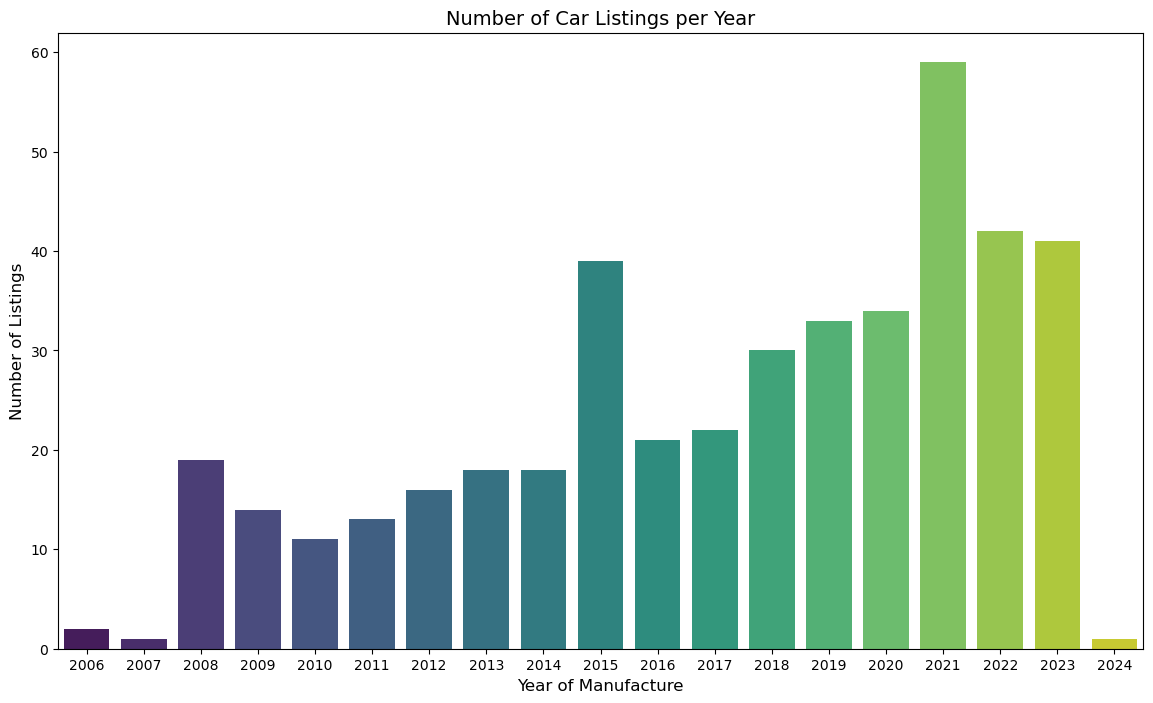

In [131]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Year', data=df_filtered, palette='viridis')
plt.title('Number of Car Listings per Year', fontsize=14)
plt.xlabel('Year of Manufacture', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.show()


### Scatter Plot
Shows car prices over the years, giving an impression of the relationship between year and price

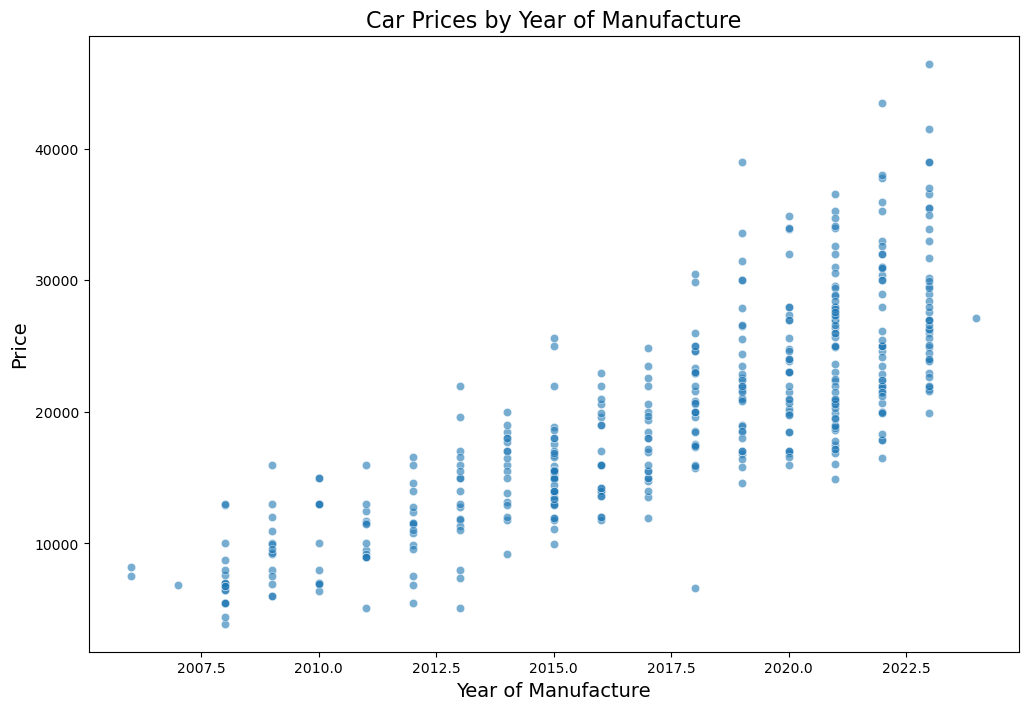

In [134]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Year', y='Price', data=df_filtered, alpha=0.6)
plt.title('Car Prices by Year of Manufacture', fontsize=16)
plt.xlabel('Year of Manufacture', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()


# Part 3: Question

Pose a question that you believe can be answered from the data. This should be in a clearly identified section in the same notebook.

### How does the year of manufacture affect the price of cars? Is there a clear trend that shows depreciation or appreciation over time?

# Part 4: Reflection

Insert here a reflection of your process. Did you feel you did the most efficient process to clean the dataset? Would your process be repeatable if you got a new dataset regularly with additional listings, or would it require much manual effort with each effort? Do you feel you adequately explored the dataset?   Do you feel your question is a good data science question (e.g. answerable, interesting, and at the right granularity).  

This section will not influence your grade on the above sections, so please feel free to be honest.

* Yes, I feel like I did an efficient process to clean the dataset. But while doing EDA ,I felt like I missed a few details.

* Yes, the process will be repeatable if I got a new dataset regularly with additional listings.

* No, I feel like I should have gone through each row carefully, (though I did)

* Yes , I feel liek my question is interesting and answerable .